# **딥러닝 시계열 모델을 이용한 주식 데이터 예측**

In [1]:
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 807.3 kB/s eta 0:00:00


In [2]:
# @title 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import FinanceDataReader as fdr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import accuracy_score

In [3]:
# @title 삼성전자 데이터 불러오기
samsung = fdr.DataReader('005930', '2018')
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1593 entries, 2018-01-02 to 2024-06-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1593 non-null   int64  
 1   High    1593 non-null   int64  
 2   Low     1593 non-null   int64  
 3   Close   1593 non-null   int64  
 4   Volume  1593 non-null   int64  
 5   Change  1593 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 87.1 KB


In [4]:
# @title 하이브 엔터테이먼트 데이터 불러오기
hybe = fdr.DataReader('352820')
hybe.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-06-17,201500,203500,199100,202500,204260,0.009975
2024-06-18,203000,203000,199800,199900,216279,-0.012840
2024-06-19,200500,201000,199500,200500,160180,0.003002
2024-06-20,200500,205000,199900,202500,260509,0.009975
2024-06-21,202500,202500,200000,200000,121738,-0.012346


In [5]:
# @title Tesla 데이터 불러오기
tesla = fdr.DataReader('TSLA', '2018') #달러 기준
tesla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


# 시각화

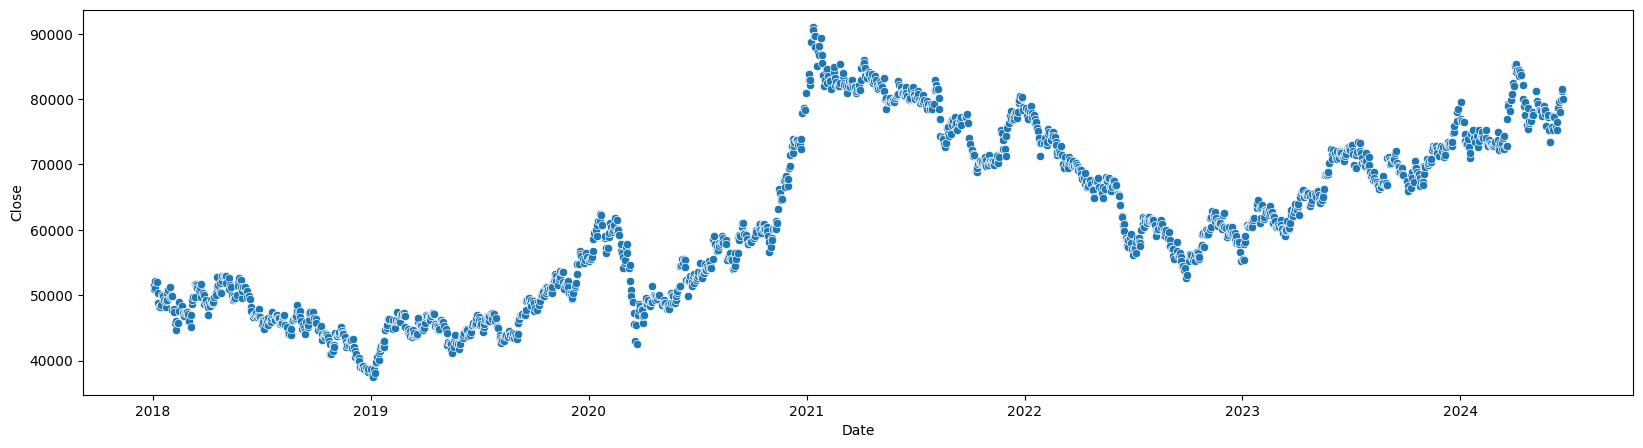

In [6]:
# @title 삼성전자
plt.figure(figsize=(20,5))
sns.scatterplot(x='Date', y = 'Close', data=samsung)
plt.show()

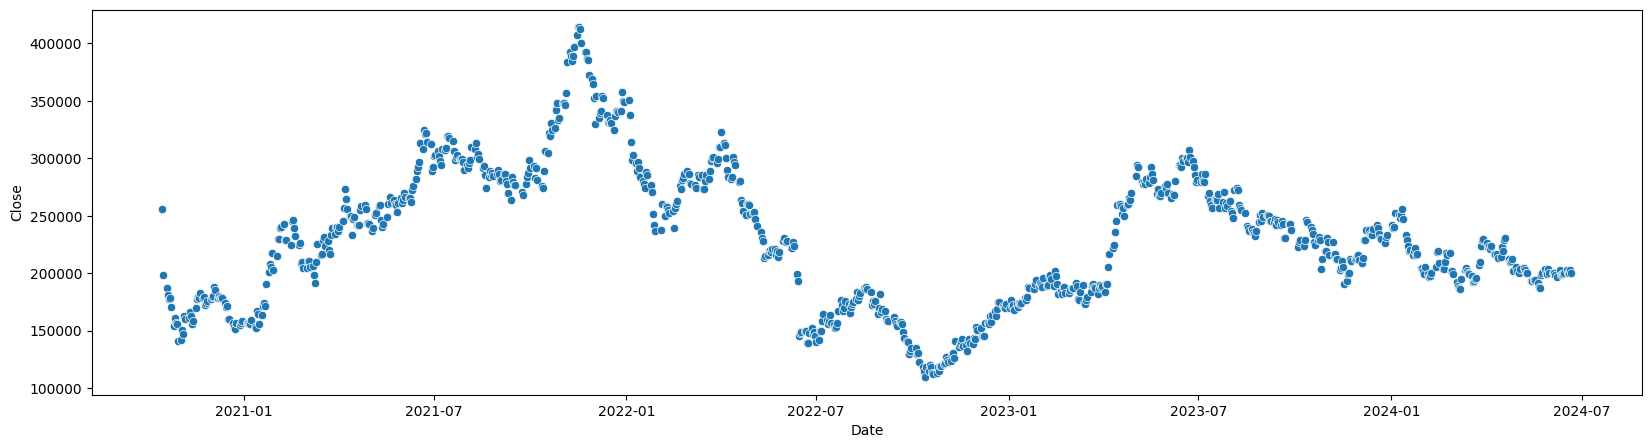

In [7]:
# @title 하이브 엔터테이먼트
plt.figure(figsize=(20,5))
sns.scatterplot(x='Date', y = 'Close', data=hybe)
plt.show()

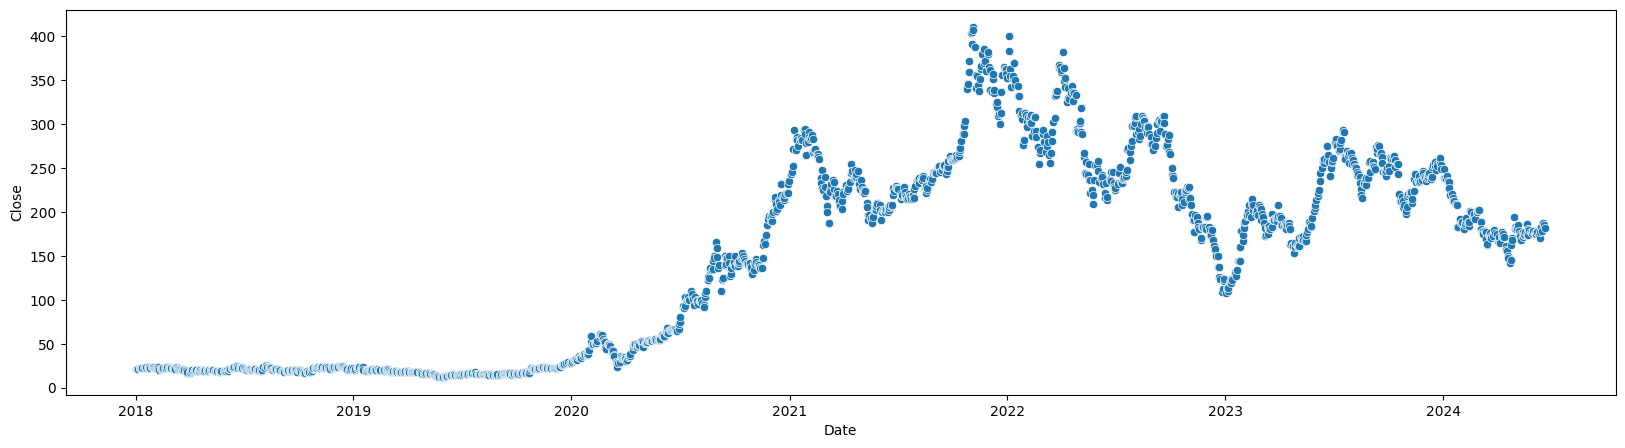

In [8]:
# @title 테슬라
plt.figure(figsize=(20,5))
sns.scatterplot(x='Date', y = 'Close', data=tesla)
plt.show()

# 삼성전자 LSTM 모델링

In [9]:
# @title 데이터 정규화
scaler = StandardScaler()
df = pd.DataFrame(StandardScaler().fit_transform(samsung), columns=samsung.columns, index=samsung.index)

In [10]:
# @title 정규화 및 Train/Test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1274, 5), (1274,), (319, 5), (319,))

In [11]:
# @title 시퀀스 데이터셋 생성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [12]:
# @title 데이터셋 확인
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [13]:
# @title 모델링
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh'),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 20, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16865 (65.88 KB)
Trainable params: 16865 (65.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# @title 모델학습
history = model.fit(train_data, validation_data=(test_data), epochs=50, batch_size=32, shuffle=False)

Epoch 1/50
40/40 [==============================] - 11s 55ms/step - loss: 0.1563 - mse: 0.3453 - val_loss: 0.1461 - val_mse: 0.2937
Epoch 2/50
40/40 [==============================] - 2s 38ms/step - loss: 0.1506 - mse: 0.3140 - val_loss: 0.1937 - val_mse: 0.3917
Epoch 3/50
40/40 [==============================] - 2s 40ms/step - loss: 0.2763 - mse: 0.6341 - val_loss: 0.1536 - val_mse: 0.3093
Epoch 4/50
40/40 [==============================] - 2s 60ms/step - loss: 0.2678 - mse: 0.5641 - val_loss: 0.3994 - val_mse: 0.8262
Epoch 5/50
40/40 [==============================] - 2s 37ms/step - loss: 0.2493 - mse: 0.5743 - val_loss: 0.1447 - val_mse: 0.2894
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.1760 - mse: 0.3585 - val_loss: 0.1067 - val_mse: 0.2140
Epoch 7/50
40/40 [==============================] - 2s 38ms/step - loss: 0.1575 - mse: 0.3227 - val_loss: 0.0855 - val_mse: 0.1709
Epoch 8/50
40/40 [==============================] - 1s 36ms/step - loss: 0.1515 - 

In [15]:
# @title 예측값 생성
pred = model.predict(test_data)
pred.shape

10/10 [==============================] - 1s 8ms/step


(299, 1)

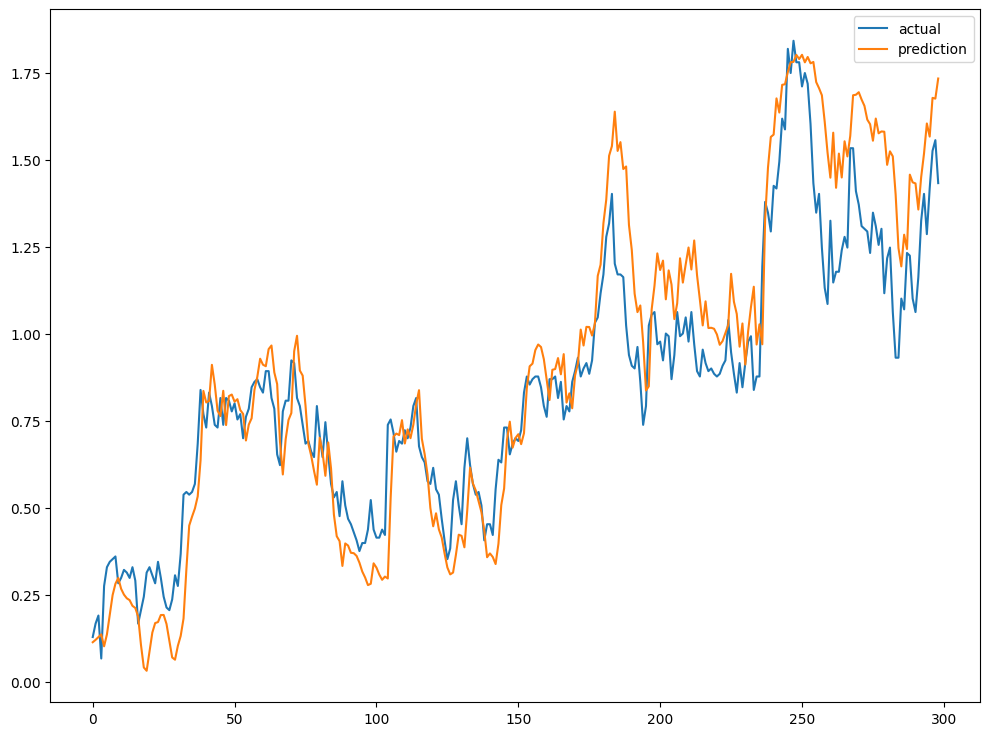

In [16]:
# @title 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 하이브 LSTM 모델링

In [17]:
# @title 데이터 정규화
scaler = StandardScaler()
df = pd.DataFrame(StandardScaler().fit_transform(hybe), columns=hybe.columns, index=hybe.index)

In [18]:
# @title 정규화 및 Train/Test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((727, 5), (727,), (182, 5), (182,))

In [19]:
# @title 시퀀스 데이터셋 생성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [20]:
# @title 데이터셋 확인
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [21]:
# @title 모델링
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh'),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 20, 32)            192       
                                                                 
 lstm_2 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16865 (65.88 KB)
Trainable params: 16865 (65.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# @title 모델학습
history = model.fit(train_data, validation_data=(test_data), epochs=50, batch_size=32, shuffle=False)

Epoch 1/50
23/23 [==============================] - 5s 90ms/step - loss: 0.1771 - mse: 0.3612 - val_loss: 0.0614 - val_mse: 0.1228
Epoch 2/50
23/23 [==============================] - 1s 36ms/step - loss: 0.3455 - mse: 0.7583 - val_loss: 0.0373 - val_mse: 0.0746
Epoch 3/50
23/23 [==============================] - 1s 36ms/step - loss: 0.3719 - mse: 0.8942 - val_loss: 0.0412 - val_mse: 0.0823
Epoch 4/50
23/23 [==============================] - 1s 34ms/step - loss: 0.3804 - mse: 0.8972 - val_loss: 0.0792 - val_mse: 0.1584
Epoch 5/50
23/23 [==============================] - 1s 39ms/step - loss: 0.3371 - mse: 0.7807 - val_loss: 0.0475 - val_mse: 0.0950
Epoch 6/50
23/23 [==============================] - 1s 40ms/step - loss: 0.2303 - mse: 0.5177 - val_loss: 0.0832 - val_mse: 0.1664
Epoch 7/50
23/23 [==============================] - 1s 38ms/step - loss: 0.1607 - mse: 0.3502 - val_loss: 0.0473 - val_mse: 0.0945
Epoch 8/50
23/23 [==============================] - 1s 40ms/step - loss: 0.0820 - m

In [23]:
# @title 예측값 생성
pred = model.predict(test_data)
pred.shape

6/6 [==============================] - 1s 9ms/step


(162, 1)

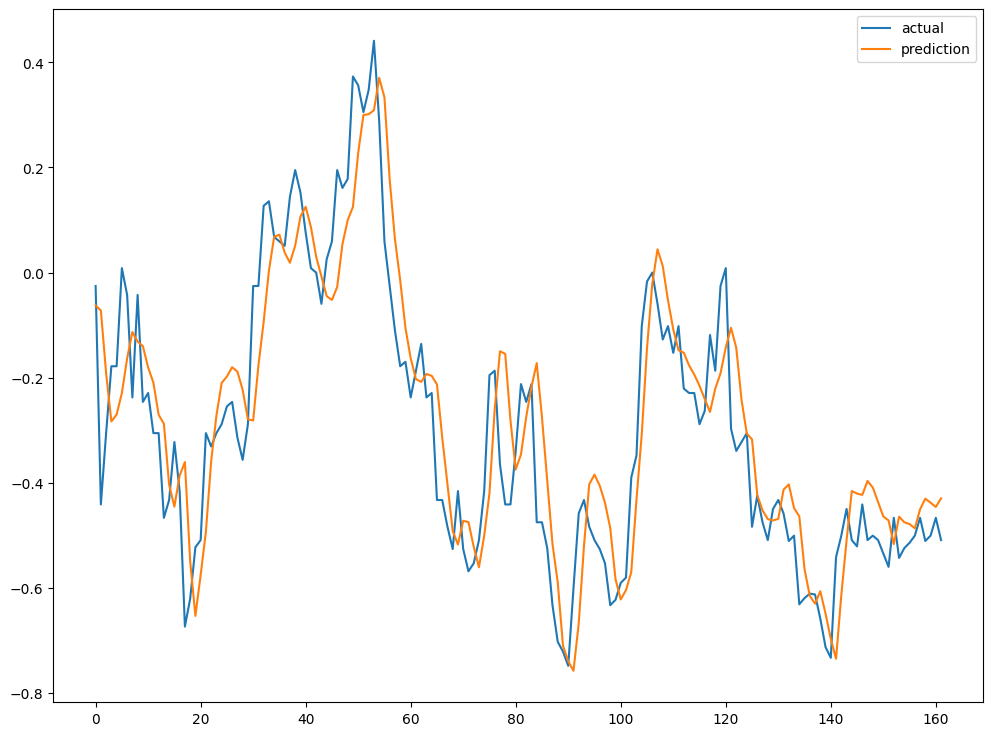

In [24]:
# @title 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# TESLA LSTM 모델링

In [25]:
# @title 데이터 정규화
scaler = StandardScaler()
df = pd.DataFrame(StandardScaler().fit_transform(tesla), columns=tesla.columns, index=tesla.index)

In [26]:
# @title 정규화 및 Train/Test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1301, 5), (1301,), (326, 5), (326,))

In [27]:
# @title 시퀀스 데이터셋 생성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [28]:
# @title 데이터셋 확인
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [29]:
# @title 모델링
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh'),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 32)            192       
                                                                 
 lstm_4 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16865 (65.88 KB)
Trainable params: 16865 (65.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# @title 모델학습
history = model.fit(train_data, validation_data=(test_data), epochs=50, batch_size=32, shuffle=False)

Epoch 1/50
41/41 [==============================] - 6s 50ms/step - loss: 0.2087 - mse: 0.4444 - val_loss: 0.0181 - val_mse: 0.0362
Epoch 2/50
41/41 [==============================] - 1s 34ms/step - loss: 0.4290 - mse: 0.9691 - val_loss: 0.1270 - val_mse: 0.2545
Epoch 3/50
41/41 [==============================] - 1s 35ms/step - loss: 0.3480 - mse: 0.7621 - val_loss: 0.1194 - val_mse: 0.2389
Epoch 4/50
41/41 [==============================] - 2s 37ms/step - loss: 0.0987 - mse: 0.2038 - val_loss: 0.1193 - val_mse: 0.2386
Epoch 5/50
41/41 [==============================] - 2s 45ms/step - loss: 0.1112 - mse: 0.2245 - val_loss: 0.0435 - val_mse: 0.0869
Epoch 6/50
41/41 [==============================] - 3s 62ms/step - loss: 0.1678 - mse: 0.3390 - val_loss: 0.0439 - val_mse: 0.0879
Epoch 7/50
41/41 [==============================] - 2s 37ms/step - loss: 0.1982 - mse: 0.4090 - val_loss: 0.0657 - val_mse: 0.1313
Epoch 8/50
41/41 [==============================] - 1s 34ms/step - loss: 0.1001 - m

In [31]:
# @title 예측값 생성
pred = model.predict(test_data)
pred.shape

10/10 [==============================] - 1s 8ms/step


(306, 1)

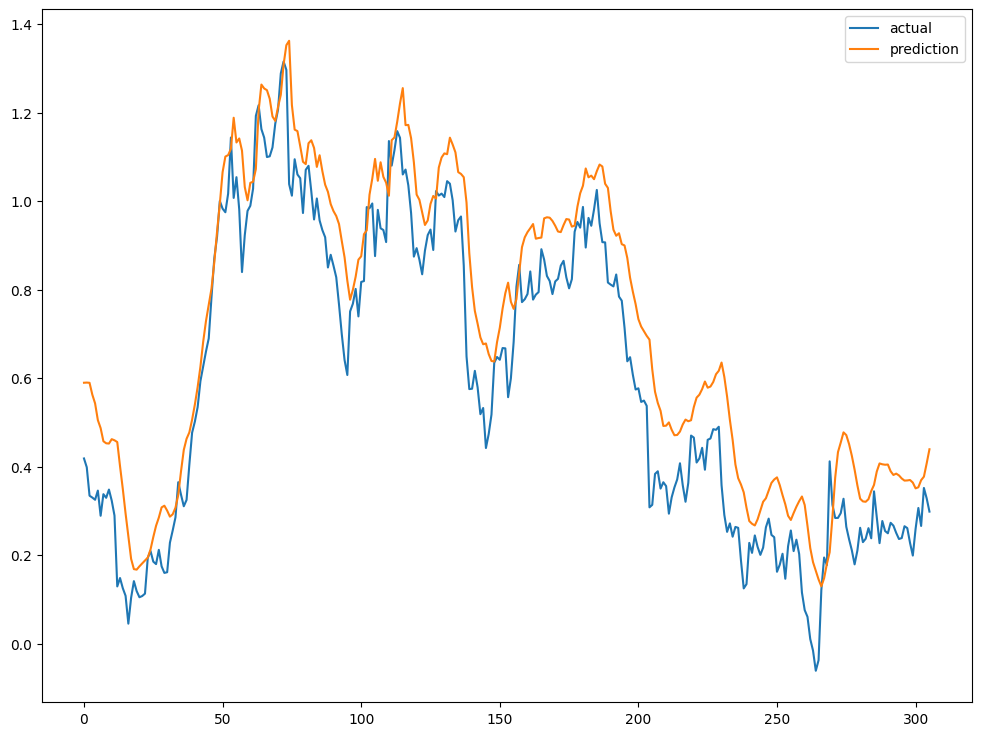

In [32]:
# @title 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()